# Major assumptions of Cauasl Inference:
1. There are no unobserved confounding factors (Affects BOTH treatment and outcomes)
2. Every class of people (X) should be distributed across both treatment and control groups. (Need not be equally) Otherwise, counterfactual cannot be estimated.

The fundamental problem in Causal Inference is the impossibility of simultaneously observing the same unit (e.g., a person, a group, or an entity) in both the treated and untreated states. And this is solved by building counter factuals for each unit. There are two common ways of building these counter factuals:

1. Co-variate adjustment (Machine Learning Models - Depending on the model used, it can be parametric)
2. Propensity Scores (Non-Parametric)
3. Matching - Exact Neighbour | Nearest Neighbour.

In [1]:
import dowhy
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('lalonde.csv')

In [3]:
df.tail()

,ID,Training,Age,Education_years,Married,No_Degree,Wage_1974,Wage_1975,Wage_1978
440,440,True,33,12,1,0,20279.95,10941.35,15952.600
441,441,True,25,14,1,0,35040.07,11536.57,36646.950
442,442,True,35,9,1,1,13602.43,13830.64,12803.970
443,443,True,35,8,1,1,13732.07,17976.15,3786.628
444,444,True,33,11,1,1,14660.71,25142.24,4181.942


## Does completion of Training increase wages?

In [31]:
#Create DAG - Causal Model

g = """digraph {
Training;
No_Degree;
Age;
Education_years;
Married;
Wage_1974;
Wage_1978;

Training -> Wage_1978;
Education_years -> Wage_1978;
Married -> Wage_1978;
Wage_1974 -> Wage_1978;
No_Degree -> Wage_1978;
Age -> Wage_1978;


Education_years -> Training;
No_Degree -> Training;
Married -> Training;

}"""

In [5]:
from dowhy import CausalModel

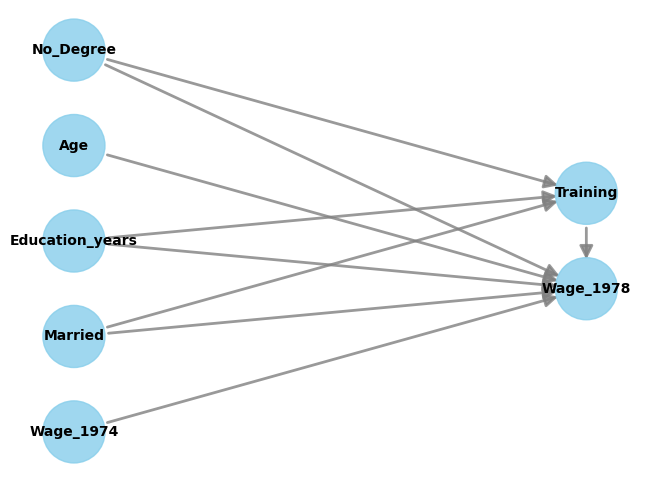

In [32]:
treatment_col = "Training"
outcome_col = "Wage_1978"

model = CausalModel(data=df,
                    treatment = treatment_col,
                   outcome=outcome_col,
                   graph=g)

model.view_model()

In [7]:
estimands = model.identify_effect(proceed_when_unidentifiable = True)
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                     
───────────(E[Wage_1978|Married,No_Degree,Education_years])
d[Training]                                                
Estimand assumption 1, Unconfoundedness: If U→{Training} and U→Wage_1978 then P(Wage_1978|Training,Married,No_Degree,Education_years,U) = P(Wage_1978|Training,Married,No_Degree,Education_years)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [33]:
g = """digraph {
Training;
No_Degree;
Education_years;
Married;
Wage_1978;

Training -> Wage_1978;

Education_years -> Wage_1978;
Education_years -> Training;

Married -> Wage_1978;
Married -> Training;

No_Degree -> Wage_1978;
No_Degree -> Training;
}"""

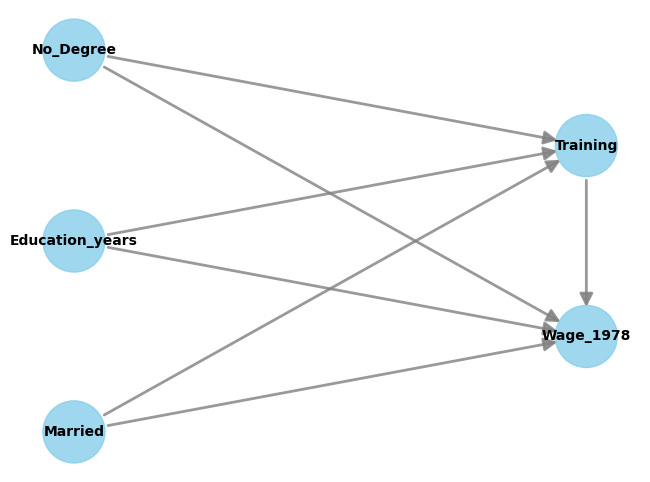

In [34]:
model = CausalModel(data=df,
                    treatment = treatment_col,
                   outcome=outcome_col,
                   graph=g)

model.view_model()

In [27]:
method = "backdoor.linear_regression"
desired_effect = "ate" #Average Treatment Effect

estimate = model.estimate_effect(estimands,
                                method_name=method,
                                target_units=desired_effect,
                                 confidence_intervals = True,
                                 test_significance = True,
                                method_params={"weighting_scheme":"ips_weight"})

C:\Users\dskcy\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [28]:
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 1634.767865553199


In [29]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                     
───────────(E[Wage_1978|Married,No_Degree,Education_years])
d[Training]                                                
Estimand assumption 1, Unconfoundedness: If U→{Training} and U→Wage_1978 then P(Wage_1978|Training,Married,No_Degree,Education_years,U) = P(Wage_1978|Training,Married,No_Degree,Education_years)

## Realized estimand
b: Wage_1978~Training+Married+No_Degree+Education_years
Target units: ate

## Estimate
Mean value: 1634.767865553199
p-value: [0.01088416]
95.0% confidence interval: [[ 378.3785414  2891.15718971]]



In [15]:
estimate.interpret()

Increasing the treatment variable(s) [Training] from 0 to 1 causes an increase of 1627.257614677097 in the expected value of the outcome [['Wage_1978']], over the data distribution/population represented by the dataset.


In [23]:
# Can also make this estimate using regression - 
import statsmodels.formula.api as smf

reg_model_all = smf.ols(formula = 'Wage_1978 ~ Training + Married + No_Degree + Education_years', data=df)
ols_all = reg_model_all.fit()
print('Effect of training: \n coeff: \t', ols_all.params['Training[T.True]'],
     '\n p-value: \t', ols_all.pvalues.loc['Training[T.True]'],
     '\n 95% CI: \t', ols_all.conf_int(alpha=0.05).loc['Training[T.True]'].values)

Effect of training: 
 coeff: 	 1634.767865553199 
 p-value: 	 0.010884162642537668 
 95% CI: 	 [ 378.3785414  2891.15718971]


## Confounder bias

When certain confounder variables are omitted

## Collider bias

When certain collider variables are omitted

# Validation

In [ ]:
for k in list(range(0,4)):
    print(f'k={k}')
    refuter_object = model.refute_graph(k=k,
                                       independence_test = {'test_for_continuous' : 'partial_correlation',
                                                           'test_for_discrete' : 'conditional_mutual_information'})
    print(refuter_object)

In [37]:
refutation_list = []
inspect_refutations = True
refuter_list = ["bootstrap_refuter", "data_subset_refuter", "random_common_cause"]

In [38]:
%%capture

for refuter in refuter_list:
    ref = model.refute_estimate(estimands, estimate, method_name = refuter)
    refutation_list.append(ref)

In [39]:
refuter_count = 1
if inspect_refutations is True:
    for refutation in refutation_list:
        print(f"################# Refutation {refuter_count} ####################")
        print(refutation)
        refuter_count += 1

################# Refutation 1 ####################
Refute: Bootstrap Sample Dataset
Estimated effect:1634.767865553199
New effect:1586.7247051767504
p value:0.92

################# Refutation 2 ####################
Refute: Use a subset of data
Estimated effect:1634.767865553199
New effect:1621.436170760554
p value:0.96

################# Refutation 3 ####################
Refute: Add a random common cause
Estimated effect:1634.767865553199
New effect:1636.4975495814247
p value:0.9199999999999999



# Counter Factuals

In [15]:
treatment_value_treated = True
treatment_value_control = False

dataset_copy = model._data.copy()  # copy because doWhy adds columns

mean_outcome = dataset_copy.loc[:, outcome_col].mean()
print(f'Actual mean outcome [all participants]: {mean_outcome}')

def get_cohort_outcome(
    df: pd.DataFrame,
    col_selector,
    cohort_value,
):
    cohort_rows = df[df[col_selector] == cohort_value]
    mean_outcome = cohort_rows.loc[:, outcome_col].mean()    
    return mean_outcome

mean_outcome_control = get_cohort_outcome(
    dataset_copy,
    treatment_col,
    treatment_value_control,
)
print(f'Actual mean outcome [control group]: {mean_outcome_control}')

mean_outcome_treated = get_cohort_outcome(
    dataset_copy,
    treatment_col,
    treatment_value_treated,
)
print(f'Actual mean outcome [treated group]: {mean_outcome_treated}')

Actual mean outcome [all participants]: 5300.763698561798
Actual mean outcome [control group]: 4554.801126
Actual mean outcome [treated group]: 6349.143530270271


In [18]:
# "do(x): Given a value x for the treatment, returns the 
# expected value of the outcome when the treatment is 
# intervened to a value x."

cf_estimate_control = estimate.estimator.do(
    x=treatment_value_control,
    data_df=dataset_copy,
)
print(f'Mean outcome if all control [all participants]: {cf_estimate_control}')

cf_estimate_treated = estimate.estimator.do(
    x=treatment_value_treated,
    data_df=dataset_copy,
)

print(f'Mean outcome if all treated [all participants]: {cf_estimate_treated}')

AttributeError: 'bool' object has no attribute 'copy'

# References
1. [Explainer - 2 Videos](https://www.youtube.com/watch?v=Od6oAz1Op2k)
2. [MIT-OCW Part1](https://www.youtube.com/watch?v=gRkUhg9Wb-I)
3. [MIT-OCW Part2](https://www.youtube.com/watch?v=g5v-NvNoJQQ)
4. [DoWhy tutorial](https://youtu.be/XwYHUv2nH34?si=CichZCz_5gHHYCvu)

In [4]:
df = pd.read_csv("CORIS.txt")

# encode famhist with dummy 0-1 variable
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
df['famhist'] = df['famhist'].astype(int)
target = 'chd'
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
#features = ['famhist','ldl','age']

df.drop('row.names', axis=1, inplace=True)
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [40]:
#Create DAG - Causal Model

g = """digraph {
sbp;
tobacco;
age;
adiposity;
famhist;
ldl;
typea;
obesity;
alcohol;
chd;

obesity -> chd;
sbp -> chd;
age -> chd;
tobacco -> chd;
ldl -> chd;
adiposity -> chd;
famhist -> chd;
typea -> chd;
alcohol -> chd;

alcohol -> obesity;
}"""

In [41]:
treatment_col = "obesity"
outcome_col = "chd"

model = CausalModel(data=df,
                    treatment = treatment_col,
                   outcome=outcome_col,
                   graph=g)

In [42]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable = True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                     
──────────(E[chd|alcohol])
d[obesity]                
Estimand assumption 1, Unconfoundedness: If U→{obesity} and U→chd then P(chd|obesity,alcohol,U) = P(chd|obesity,alcohol)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [43]:
method = "backdoor.linear_regression"
desired_effect = "ate" #Average Treatment Effect

estimate = model.estimate_effect(identified_estimand,
                                method_name=method,
                                target_units=desired_effect,
                                method_params={"weighting_scheme":"ips_weight"})

C:\Users\dskcy\anaconda3\Lib\site-packages\dowhy\causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
C:\Users\dskcy\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\dskcy\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

In [44]:
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is -0.009994145695698675
